In [3]:
include("includes.jl");

### Setup

In [2]:
@everywhere measurements, measurements_mask = load_experiments()
@everywhere n_measurements = size(measurements)[1]

@everywhere prior = Uniform(8,11)

@everywhere Θ₀ = [5*pi/180, 0]
@everywhere function dΘ(g)
    Θ -> [Θ[2], -g*sin(Θ[1])/8]
end

@everywhere grid = [0; measurements[1,:][measurements_mask[1,:] .!= 0]]

@everywhere loglikelihood = (n, g) ->
    let
        c = .01
        Gg = rk4s(dΘ(g[1]), Θ₀, grid[1:n+1], 0.01) 
        b = log.(abs.(c ./ (c + Gg[2:end,1]))).^2
        (sum(b)/0.5, b[end]/2)
    end

full_loglikelihood = g -> loglikelihood(11, g[1])[1];

Interact.Slider{Int64}(9: "input-3" = 1 Int64 , "", 1, 1:11, "horizontal", true, "d", true)

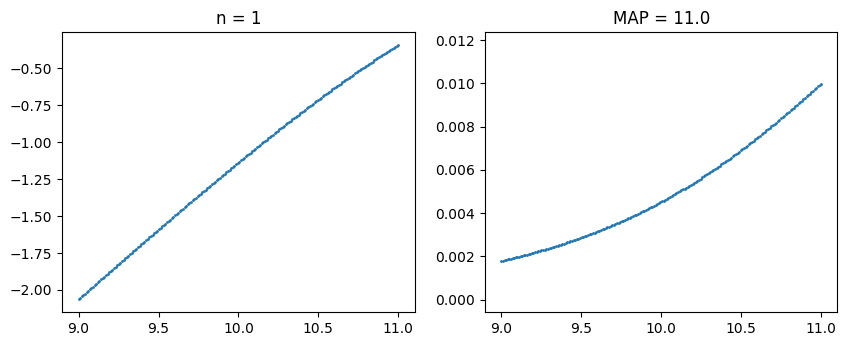

In [19]:
fig = figure()
evaluation_mesh=collect(0:0.01:30)
mesh = linspace(9,11,200)

@manipulate for n = slider(1:11,value=1)
    lhood = -(g -> loglikelihood(n, g)[1]).(mesh)
    elhood = exp.(lhood)
    elhood = elhood / sum(elhood)
    map = mesh[findmax(lhood)[2]]
    withfig(fig) do
        subplot(2,2,1)
        title("n = $(n)")
        scatter(mesh, lhood,s=1)    
        subplot(2,2,2)
        title("MAP = $(map)")
        scatter(mesh, elhood,s=1)
    end
end

### Metropolis Hastings with gaussian noise

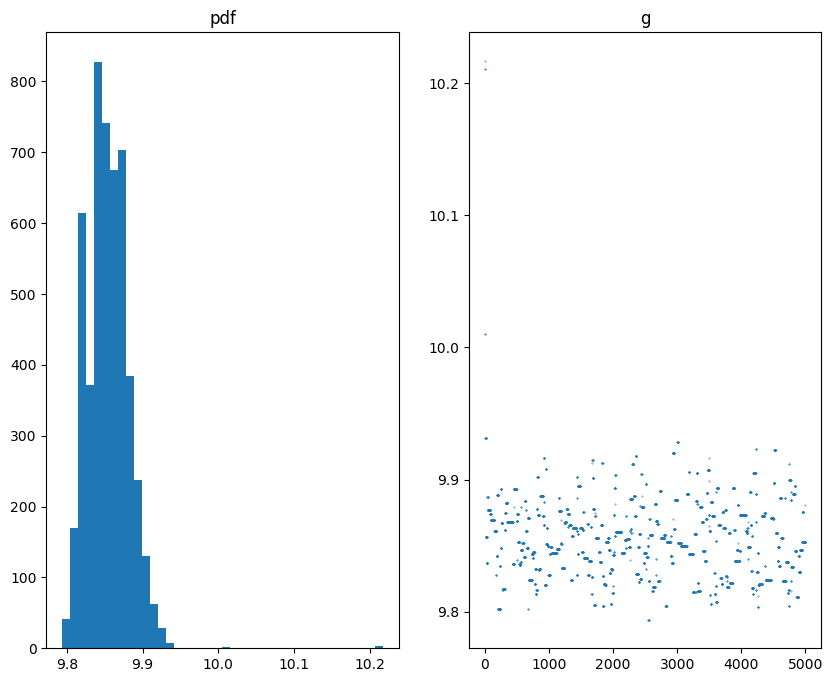

317 / 5000 of the sampled particles were accepted (6.0%)
        
The expectation estimation is of 9.85493759060652


In [4]:
function GaussianMetropolisHastings(K, prior, ϕ, γ)
    x₀ = rand(prior, 1)
    
    X = zeros(K, length(x₀))
    Y = zeros(K, length(x₀))
    W = zeros(K)
    accepted = 0
    
    w = MvNormal(γ^2*eye(length(x₀)))
    x = x₀
    ϕₓ = ϕ(x)
    
    for k=1:K
        y = x + rand(w)
        ϕₙ = ϕ(y)
        if rand() < min(1, (pdf(prior, y[1])/pdf(prior, x[1]))*exp(ϕₓ-ϕₙ))
            x = y
            ϕₓ = ϕₙ
            accepted += 1
        end
        
        W[k] = ϕₙ
        Y[k,:] = y
        X[k,:] = x
    end
    X, Y, exp.(-W), accepted
end

out = GaussianMetropolisHastings(5000, prior, full_loglikelihood, 0.5)
plotMCMC(out)

### Sequential Monte Carlo with gaussian noise

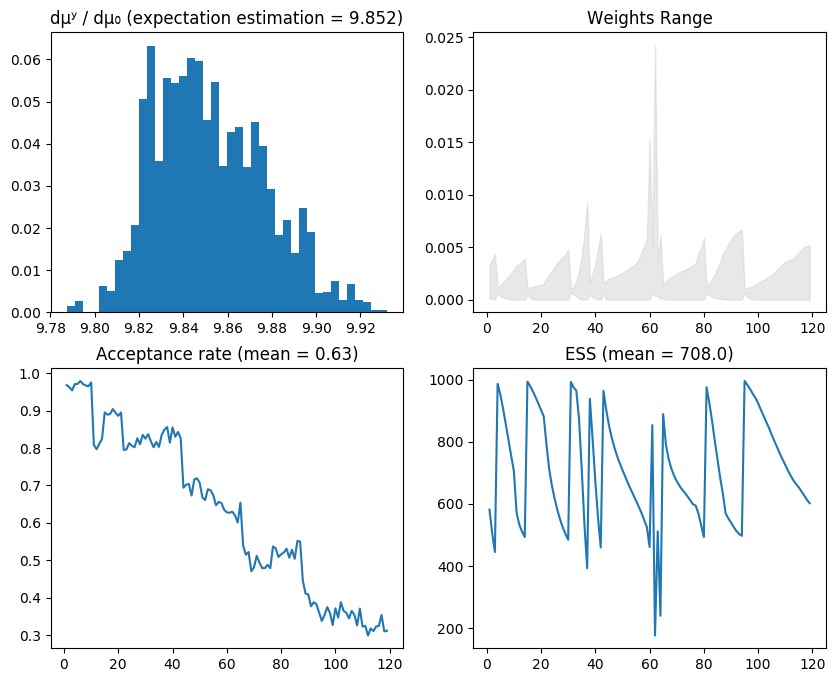

In [7]:
function GaussianSequentialMonteCarlo(X₀, p, prior, ll; μ=0.1)
    # initialization
    N,d = size(X₀)
    w = MvNormal(μ^2 * eye(d))

    X = SharedArray{Float64}(X₀)
    dX = SharedArray{Float64,2}(X₀)
    
    alphas = SharedArray{Float64}(N)
    W = SharedArray{Float64}(N)
    
    acceptance_rate = ones(p) ./ N
    ess = zeros(p)
    maxweights = zeros(p)
    minweights = zeros(p)
    
    # initialize
    s = @parallel (+) for i=1:N
        W[i] = exp(-ll(1, X[i,:])[1])
    end
    @sync @parallel for i=1:N
        W[i] /= s
    end
    
    for n = 1:p
        # update
        copy!(dX, rand(w, N)')
        rand!(alphas)
        
        @sync @parallel for i=1:N
            W[i] = log(W[i])
        end
        
        acceptance_rate[n] *= @parallel (+) for i=1:N
            accepted = 0
            
            xₙ₋₁ = X[i,:]
            xₙ = xₙ₋₁ + dX[i,:]

            wₙ,dwₙ= ll(n, xₙ)
            wₙ₋₁,dwₙ₋₁ = ll(n, xₙ₋₁)
            
            if alphas[i] < min(1, exp(-wₙ + wₙ₋₁))
                X[i,:] = xₙ
                accepted += 1
            end
            W[i] += -dwₙ₋₁
            
            accepted
        end

        # normalize weights
        s = @parallel (+) for i=1:N
            W[i] = exp(W[i])
        end
        
        @sync @parallel for i=1:N
            W[i] /= s
        end
        
        minweights[n] = minimum(W)
        maxweights[n] = maximum(W)
        
        # resample
        ess[n] = 1 / vecdot(W,W)
        if ess[n] < N/2            
            perm = rand(Categorical(W[:]), N)
            @sync @parallel for i=1:N
                X[i,:] = X[perm[i], :]
                W[i] = 1/N
            end 
        end
    end
    
    W,X,acceptance_rate,ess,minweights,maxweights
end

N = 1000
X₀ = reshape(rand(prior, N), N, 1)

modulo_llhood = (n, g) -> loglikelihood(div(n - n%11,11)+1, g)

outs = GaussianSequentialMonteCarlo(X₀, 119, prior, modulo_llhood, μ=0.1)
plotSMC(outs);

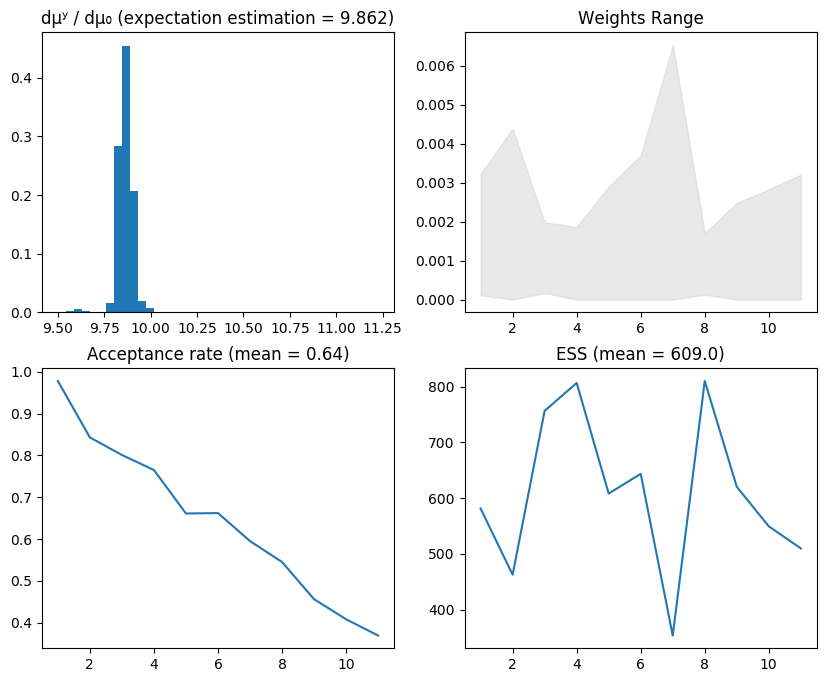

In [8]:
outs = GaussianSequentialMonteCarlo(X₀, 11, prior, loglikelihood, μ=0.1)
plotSMC(outs);